file paths

In [1]:
train_file = '/work/data/splits/splits_0.05/train.json'
val_file = '/work/data/splits/splits_0.05/val.json'
test_file = '/work/data/splits/splits_0.05/test.json'

path_to_save = '/work/data/models'
path_to_res = '/work/data/results/31_5_2023_tp_graph_5re.txt'

import

In [2]:
%load_ext autoreload
%autoreload 2
import json
import dgl
from sklearn.metrics import f1_score
import torch as th
import dgl.nn.pytorch as dglnn
import torch.nn as nn
from dgl.dataloading import GraphDataLoader
import torch.nn.functional as F
import networkx as nx
import warnings
from feature_extraction.base_featurizer import BaseFeaturizer
import torch
from graph_construction.tps_graph import create_dummy_dgl_graph, tps_graph
import numpy as np

from dgl_classifier.trainer import GraphDataset,snap_pred, tps_to_dgl, get_clasification_vec,\
tps_graph_const, extract_data, runner


import warnings

from preprocessing.utils import load_BGPS_from_json
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [3]:
#seed
dgl.seed(1223)

Model

In [4]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.RelGraphConv(in_dim, hidden_dim, 8)
        #self.conv1 = dglnn.GraphConv(in_dim, hidden_ˇdim)
        self.conv2 = dglnn.RelGraphConv(hidden_dim, hidden_dim, 8)
        #self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h, rel_types):
        # Apply graph convolution and activation.
        h = F.relu(self.conv1(g, h, rel_types))
        h = F.relu(self.conv2(g, h, rel_types))
        with g.local_scope():
            g.ndata['node_features'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'node_features')
            return F.softmax( self.classify(hg), dim=1)
model = Classifier(113, 20, 2)

hyperparameters

In [5]:
early_stop =100
model = Classifier(113, 20, 2)
lr = 0.01
wd = 5e-4
epochs = 100

In [6]:
train_dataloader, val_dataloader, test_dataloader = extract_data(train_file, val_file, test_file, community_no=30, batch_size = 50, verbose=True)

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return th.as_tensor(data, dtype=dtype)


# of predicate feats not in validation 37
# of predicate feats not in test 3
Training dataset size 139
Validation dataset size 50
Test dataset size 45


In [7]:
runner(train_dataloader,val_dataloader,test_dataloader,model, early_stop, lr, wd, epochs, path_to_res)

Epoch 1
--------------------------------------------------------------
Epoch:    1        1 Batch loss: 0.695453 Batch F1: 0.6197183098591549
Epoch:    1        2 Batch loss: 0.644735 Batch F1: 0.5500000000000002
Epoch:    1        3 Batch loss: 0.674105 Batch F1: 0.17391304347826084
Train Avg Loss    1: 0.671431

Train Avg F1    1: 0.4478771177791386

Val Avg Loss    1: 0.270988

Val Avg F1    1:  0.4888888888888889

Optimal Val loss (Epoch 1): 0.2709883749485016

Epoch 2
--------------------------------------------------------------
Epoch:    2        1 Batch loss: 0.632986 Batch F1: 0.48484848484848486
Epoch:    2        2 Batch loss: 0.583648 Batch F1: 0.8
Epoch:    2        3 Batch loss: 0.618180 Batch F1: 0.6976744186046512
Train Avg Loss    2: 0.611605

Train Avg F1    2: 0.6608409678177121

Val Avg Loss    2: 0.211099

Val Avg F1    2:  0.7761194029850748

Optimal Val loss (Epoch 2): 0.21109914779663086

Epoch 3
--------------------------------------------------------------
Epo

In [8]:
import json

In [9]:
results = json.load(open(path_to_res))

In [10]:
print('best f1', np.max(results['val_f1']), np.argmax(results['val_f1']))
print('best f1 val', results['val_f1'][np.argmax(results['val_f1'])])
print('corr f1 train', results['train_f1'][np.argmax(results['val_f1'])])
print('corr f1 test', results['test_f1'][np.argmax(results['val_f1'])])
print('best f1 train', np.max(results['train_f1']), np.argmax(results['train_f1']))

best f1 0.8135593220338982 14
best f1 val 0.8135593220338982
corr f1 train 0.8030654981874493
corr f1 test 0.8235294117647058
best f1 train 0.8745098039215686 45


In [11]:
import matplotlib.pyplot as plt

(0.0, 1.0)

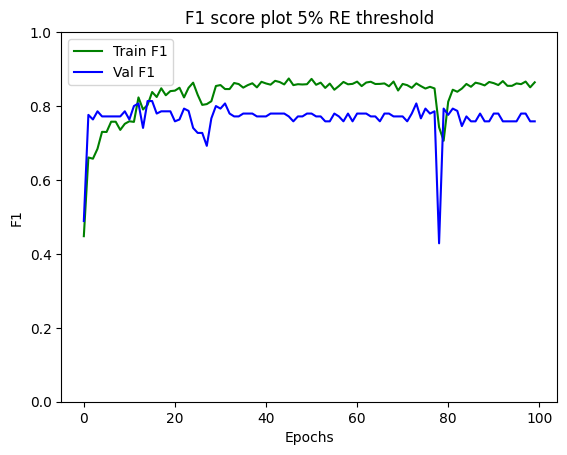

In [12]:
plt.title('F1 score plot 5% RE threshold')
plt.ylabel('F1')
plt.xlabel('Epochs')
plt.plot(results['train_f1'],'-g', label='Train F1')
plt.plot(results['val_f1'],'-b', label='Val F1')
plt.legend(loc='upper left')
plt.ylim([0.0,1.0])

In [13]:
list(results.keys())

['train_loss',
 'val_loss',
 'test_loss',
 'train_f1',
 'val_f1',
 'test_f1',
 'train_prec',
 'val_prec',
 'test_prec',
 'train_recall',
 'val_recall',
 'test_recall']

(0.0, 1.0)

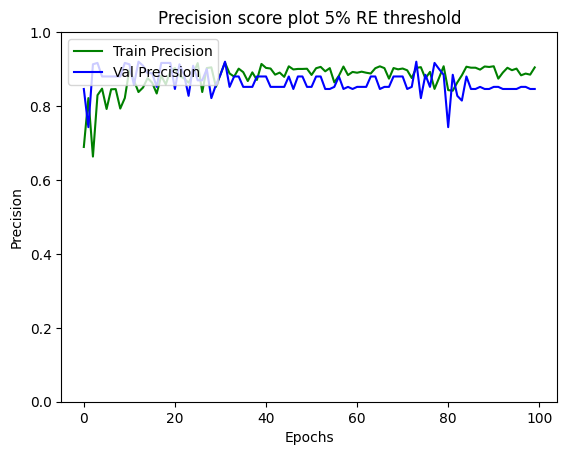

In [14]:
plt.title('Precision score plot 5% RE threshold')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.plot(results['train_prec'],'-g', label='Train Precision')
plt.plot(results['val_prec'],'-b', label='Val Precision')
plt.legend(loc='upper left')
plt.ylim([0.0,1.0])

(0.0, 1.0)

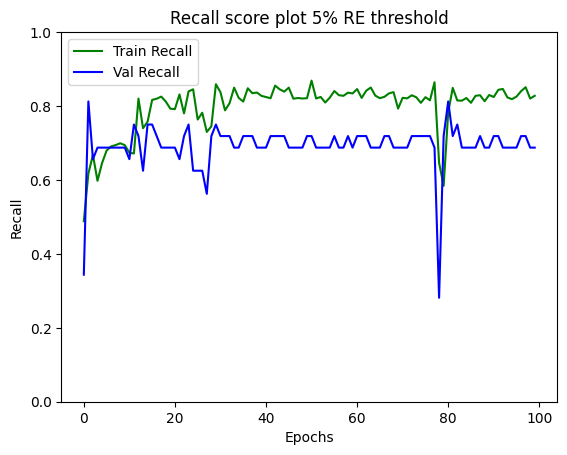

In [15]:
plt.title('Recall score plot 5% RE threshold')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.plot(results['train_recall'],'-g', label='Train Recall')
plt.plot(results['val_recall'],'-b', label='Val Recall')
plt.legend(loc='upper left')
plt.ylim([0.0,1.0])